## 모듈 선언

In [1]:
import os
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import json
from soynlp.normalizer import *
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np

`from soynlp.normalizer import *`  
한국어 분석을 위한 pure python code
- 학습데이터를 이용하지 않으면서 데이터에 존재하는 단어를 찾거나, 문장을 단어열로 분해, 혹은 품사 판별을 할 수 있는 비지도학습 접근법을 지향합니다.
- [Github Link](https://github.com/lovit/soynlp)

---



## 파일 읽기

### 1) Train Data

#### CSV file read (as DataFrame)

In [2]:
## Augment된 데이터를 읽어보자
train_data_path ="/aiffel/aiffel/train_aug_old.csv"
train_data = pd.read_csv(train_data_path)

#### Data Read (with `tail`)

In [3]:
train_data.tail()

,conversation,class
19745,희정씨 네 주말에 시간이 넘쳐나나봐 갑자기 왜그러세요 빤짝빤짝 네일했니 네 여름이라...,직장 내 괴롭힘 대화
19746,희정씨 네 주말에 시간이 넘쳐나나봐 갑자기 윗분들 손이 빤짝빤짝 네일했니 네 여름이...,직장 내 괴롭힘 대화
19747,희정씨 네 주말에 시간이 넘쳐나나봐 갑자기 왜그러세요 손이 빤짝빤짝 네일했니 네 여...,직장 내 괴롭힘 대화
19748,희정씨 주말에 네 시간이 넘쳐나나봐 갑자기 왜그러세요 아프시겠다 빤짝빤짝 네일했니 ...,직장 내 괴롭힘 대화
19749,희정씨 네 주말에 시간이 넘쳐나나봐 갑자기 왜그러세요 손이 빤짝빤짝 네일했니 네 여...,직장 내 괴롭힘 대화


---

## 데이터 변환

### 대화 데이터(`conversation`)를 `sentences`에 저장

In [4]:
# 학습할 문장이 담길 배열
sentences = []

for val in tqdm(train_data['conversation'], desc="Generate sentences.."):
    # 전처리가 된 conversation을 val로 받아오기
    sentences.append(val)

Generate sentences..: 100%|██████████| 19750/19750 [00:00<00:00, 1958148.26it/s]


In [5]:
# 대화 데이터 개수 파악
len(sentences)

19750

### 3) 대화 분류값(`class`)를 `labels`에 저장

#### `class` 값은 숫자로 변환하여 `labels`에 저장한다
- `협박 관련 대화` &rarr; `0`
- `갈취 관련 대화` &rarr; `1`
- `직장 관련 대화` &rarr; `2`  
- `기타 관련 대화` &rarr; `3`

In [6]:
labels = []

for val in tqdm(train_data['class'], desc="class label convert to num..."):    
    if '갈취' in val:
        labels.append(1)
    if '기타' in val:
        labels.append(3)
    if '직장' in val:
        labels.append(2)
    if '협박' in val:
        labels.append(0)

class label convert to num...: 100%|██████████| 19750/19750 [00:00<00:00, 1357947.35it/s]


In [7]:
len(labels)

19750

---

## 모델 학습 준비

### 1) 모델 학습용 파라미터 선언

In [8]:
# 토큰 최대 길이
MAX_LEN = 128
# 데이터 묶음 크기
BATCH_SIZE = 16
# Learning Rate
lr = 2e-5
# 훈련 횟수
EPOCH = 10

### 2) 데이터셋 분할
1. `sentences`와 `labels`를 활용
2. `8:2` 비율로 `train`, `validation` 데이터셋으로 분할
3. 분할 시 `class`별 균등 분할 (`stratify` 옵션 사용)

In [9]:
## 데이터 분류와 동일하게 학습데이터 분할
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42, stratify=train_data['class']
)

### 3) 사용하지 않는 변수 초기화

In [10]:
del train_data

### 4) 모델 선언
1. 모델: `bert-base-multilingual-cased`
2. BERT 토크나이저 사용

In [11]:
# BERT 토크나이저와 모델 준비
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=4)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---

### 5) 데이터(`train`, `validation`)를 BERT 형식으로 변환
1. `예시` &rarr; `[CLS] 안녕하세요 [SEP]`
2. 문장 구분 토큰을 추가하여 Encoding

In [12]:
# 데이터셋을 BERT 입력 형식으로 변환
train_encodings = tokenizer(train_sentences, truncation=True, padding=True, max_length=MAX_LEN) # 뒤쪽에 패딩
val_encodings = tokenizer(val_sentences, truncation=True, padding=True, max_length=MAX_LEN)

### 6) Tensor 데이터셋 생성

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(100).batch(BATCH_SIZE)

print("Train tensor dataset generated!")

Train tensor dataset generated!


In [14]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(BATCH_SIZE)

print("Validation tensor dataset generated!")

Validation tensor dataset generated!


---

## 모델 훈련

### 1) 모델 컴파일

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 2) 모델 구조 시각화

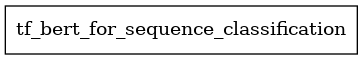

In [16]:
plot_model(model, show_shapes=True, show_layer_names=True)

### 3) 모델 훈련

In [17]:
model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCH)

Epoch 1/10
988/988 [==============================] - 505s 495ms/step - loss: 0.5197 - accuracy: 0.8103 - val_loss: 0.2567 - val_accuracy: 0.9165
Epoch 2/10
988/988 [==============================] - 486s 492ms/step - loss: 0.1846 - accuracy: 0.9379 - val_loss: 0.1356 - val_accuracy: 0.9565
Epoch 3/10
988/988 [==============================] - 486s 492ms/step - loss: 0.0869 - accuracy: 0.9715 - val_loss: 0.1364 - val_accuracy: 0.9580
Epoch 4/10
988/988 [==============================] - 486s 492ms/step - loss: 0.0546 - accuracy: 0.9823 - val_loss: 0.0653 - val_accuracy: 0.9818
Epoch 5/10
988/988 [==============================] - 486s 492ms/step - loss: 0.0392 - accuracy: 0.9875 - val_loss: 0.0600 - val_accuracy: 0.9848
Epoch 6/10
988/988 [==============================] - 486s 492ms/step - loss: 0.0341 - accuracy: 0.9892 - val_loss: 0.0549 - val_accuracy: 0.9843
Epoch 7/10
988/988 [==============================] - 486s 492ms/step - loss: 0.0320 - accuracy: 0.9890 - val_loss: 0.0667 -

### 4) 모델 평가

In [18]:
evaluation = model.evaluate(val_dataset)

247/247 [==============================] - 36s 144ms/step - loss: 0.0559 - accuracy: 0.9851


---

## submission.csv 생성해보기

### 1) 파일 읽기 (`test.json`)

In [19]:
test_data_path ="/aiffel/aiffel/dktc/data/test.json"

with open(test_data_path, "r", encoding="utf-8") as json_file:
    test = json.load(json_file)

### 2) 테스트 데이터 읽으면서 예측해보기

In [20]:
test_predicst = list()

for key in test:
    test_sentence = test[key]['text']
    
    test_encodings = tokenizer(test_sentence, truncation=True, padding=True, max_length=128, return_tensors="tf")
    
    test_predictions = model.predict({
        "input_ids": test_encodings["input_ids"],
        "token_type_ids": test_encodings["token_type_ids"],
        "attention_mask": test_encodings["attention_mask"]
    }) # [ 0.7805823,  2.6188664, -2.0281641, -0.9672525]
    test_class_probabilities = tf.nn.softmax(test_predictions.logits, axis=-1).numpy() # [[0.13297564 0.8358507  0.00801584 0.02315779]]
    test_predicted_class = np.argmax(test_class_probabilities, axis=1) # [ 1 ]
    test_predicst.append(test_predicted_class[0])

### 3) `submission.csv` 파일을 위한 `DataFrame` 생성

In [21]:
def labelnum_to_text(x):
    if x == 1 : # 갈취
        return '01'
    if x == 2 : # 직장
        return '02'
    if x == 3 : # 기타
        return '03'
    if x == 0 : # 협박 
        return '00'

submission = pd.DataFrame({'class':test_predicst}, index=list(test.keys()))
submission['class'] = submission['class'].apply(labelnum_to_text)
submission

,class
t_000,01
t_001,02
t_002,02
t_004,02
t_005,00
...,...
t_495,02
t_496,02
t_497,01
t_498,02


### 4) CSV 파일 저장

In [22]:
# 파일명 설정
file_name = "submission_test5_all_train_data_augment_stratify.csv"

In [23]:
# 파일 생성
submission.to_csv(file_name)

# 테스트 회고

1. `OOM Error`로 인해 `MAX_LEN`를 크게 테스트 해보지 못했다. (ex: `300`)
    - 약간의 파라미터 수정은 수행하였다.
        - `learning rate`, `EPOCH`
2. 검증 데이터를 임의로 설정하였다. (`train_aug_old.csv` 파일로부터)
3. `from soynlp.normalizer import *`로 전처리된 CSV 파일을 가지고 수행하였다.
4. Validation 데이터는 증강하지 않아야 함을 알게되었다.
    - 데이터 정보 유출 이슈 등
5. 데이터 EDA 관련해서 클래스에 유의미한 정보는 현재 설정한 `128` 값보다 뒤에 있는 경우가 많음을 알게 되었다.
    - 편향성 증가 우려가 있음
6. `class`를 균일하게 분할하였음에도 (`stratify`) 유의미한 향상은 없는 것 같다.